<a href="https://colab.research.google.com/github/ElenaGordienko1/ML/blob/main/ML4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏰ Домашнее задание

- 1. Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)

p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

- 2. Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
  - 2.1. Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи

- 3. Для обоих задач побороться с дисбалансом классов следующими техниками:
  - oversampling (например, SMOTE)
  - или undersampling.

Для oversampling и undersampling используйте (https://imbalanced-learn.org/)
Опишите полученный результат

Самый простой пример (желательно не использовать рандом)
```
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
```

- 4. Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle)  для ```oversampling``` и ```undersampling``` (в задачи мультиклассовой классификации), оценить метрики и описать результат.


## 1. Бинарная классификация

In [43]:
!pip install pandas scikit-learn seaborn scipy

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart_disease.csv')

df['old_and_sick'] = np.where(df['age'] >= 50, 1, 0)
df.old_and_sick = df.old_and_sick.astype('category')
df['sex'] = df['sex'].astype('category')

Y = df['old_and_sick'] # выбираем целевую переменную (категориальную)
X = df.drop('old_and_sick', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)
df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   sex                                   270 non-null    category
 1   chest pain type                       270 non-null    int64   
 2   resting blood pressure                270 non-null    int64   
 3   serum cholestoral in mg/dl            270 non-null    int64   
 4   fasting blood sugar > 120 mg/dl       270 non-null    int64   
 5   resting electrocardiographic results  270 non-null    int64   
 6   maximum heart rate achieved           270 non-null    int64   
 7   exercise induced angina               270 non-null    int64   
 8   oldpeak                               270 non-null    float64 
 9   slope of peak                         270 non-null    int64   
 10  number of major vessels               270 non-null    int64   
 11  thal  

In [45]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [46]:
X

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,sex_1
0,4,130,322,0,2,109,0,2.4,2,3,3,1,True
1,3,115,564,0,2,160,0,1.6,2,0,7,0,False
2,2,124,261,0,0,141,0,0.3,1,0,7,1,True
3,4,128,263,0,0,105,1,0.2,2,1,7,0,True
4,2,120,269,0,2,121,1,0.2,1,1,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3,172,199,1,0,162,0,0.5,1,0,7,0,True
266,2,120,263,0,0,173,0,0.0,1,0,7,0,True
267,2,140,294,0,2,153,0,1.3,2,0,3,0,False
268,4,140,192,0,0,148,0,0.4,2,0,6,0,True


### Обучаем логистическую регрессию

In [47]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)


    # Классификационный отчет

    print("\nClassification Report:\n",classification_report(Y_test, Y_test_pred))

    return model


In [48]:
train_and_evaluate(X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.31      0.40        16
           1       0.76      0.89      0.82        38

    accuracy                           0.72        54
   macro avg       0.66      0.60      0.61        54
weighted avg       0.70      0.72      0.70        54



LogisticRegression(max_iter=1000)


classification_report:

Precision:

0 (0.56) — 56% предсказанных значений, как класс 0, действительно относятся к классу 0.

1 (0.76) — 76% предсказанных значений,как класс 1, действительно относятня к классу 1.

Recall:

0 (0.31) — модель нашла 31% всех значений, которые относятся к классу 0.

1 (0.89) — модель нашла 89% всех,которые относятся к классу 1.

F1-score:

0 класс (0.40), 1 класс (0.82) — баланс Precision и Recall для каждого класса.

Accuracy = 0.72 — 72% всех предсказаний правильны.

###Создание дисбаланса

In [49]:
Y.value_counts()

,count
old_and_sick,
1,191
0,79


In [50]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, Y], axis=1)

# Разделяем на классы
majority = data[data['old_and_sick'] == 0]
minority = data[data['old_and_sick'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('old_and_sick', axis=1)
y_disbalanced = data_disbalanced['old_and_sick']

In [51]:
print(y_disbalanced.value_counts())


old_and_sick
0    79
1     7
Name: count, dtype: int64


OVERSAMLER

In [52]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_disbalanced, y_disbalanced)


In [53]:
y_res.value_counts()

,count
old_and_sick,
0,79
1,79


###Создание дерева

In [54]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train, y_train)

# Предсказания
y_pred = tree_model.predict(X_test)

In [55]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.37      0.43        27
           1       0.72      0.81      0.77        54

    accuracy                           0.67        81
   macro avg       0.61      0.59      0.60        81
weighted avg       0.65      0.67      0.65        81



In [56]:
accuracy_score(y_test, y_pred)

0.6666666666666666

In [57]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred) # ну такое


0.5925925925925926

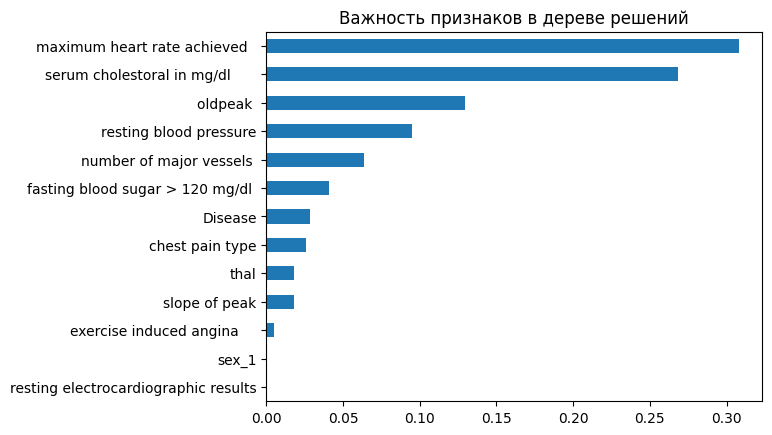

In [58]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()


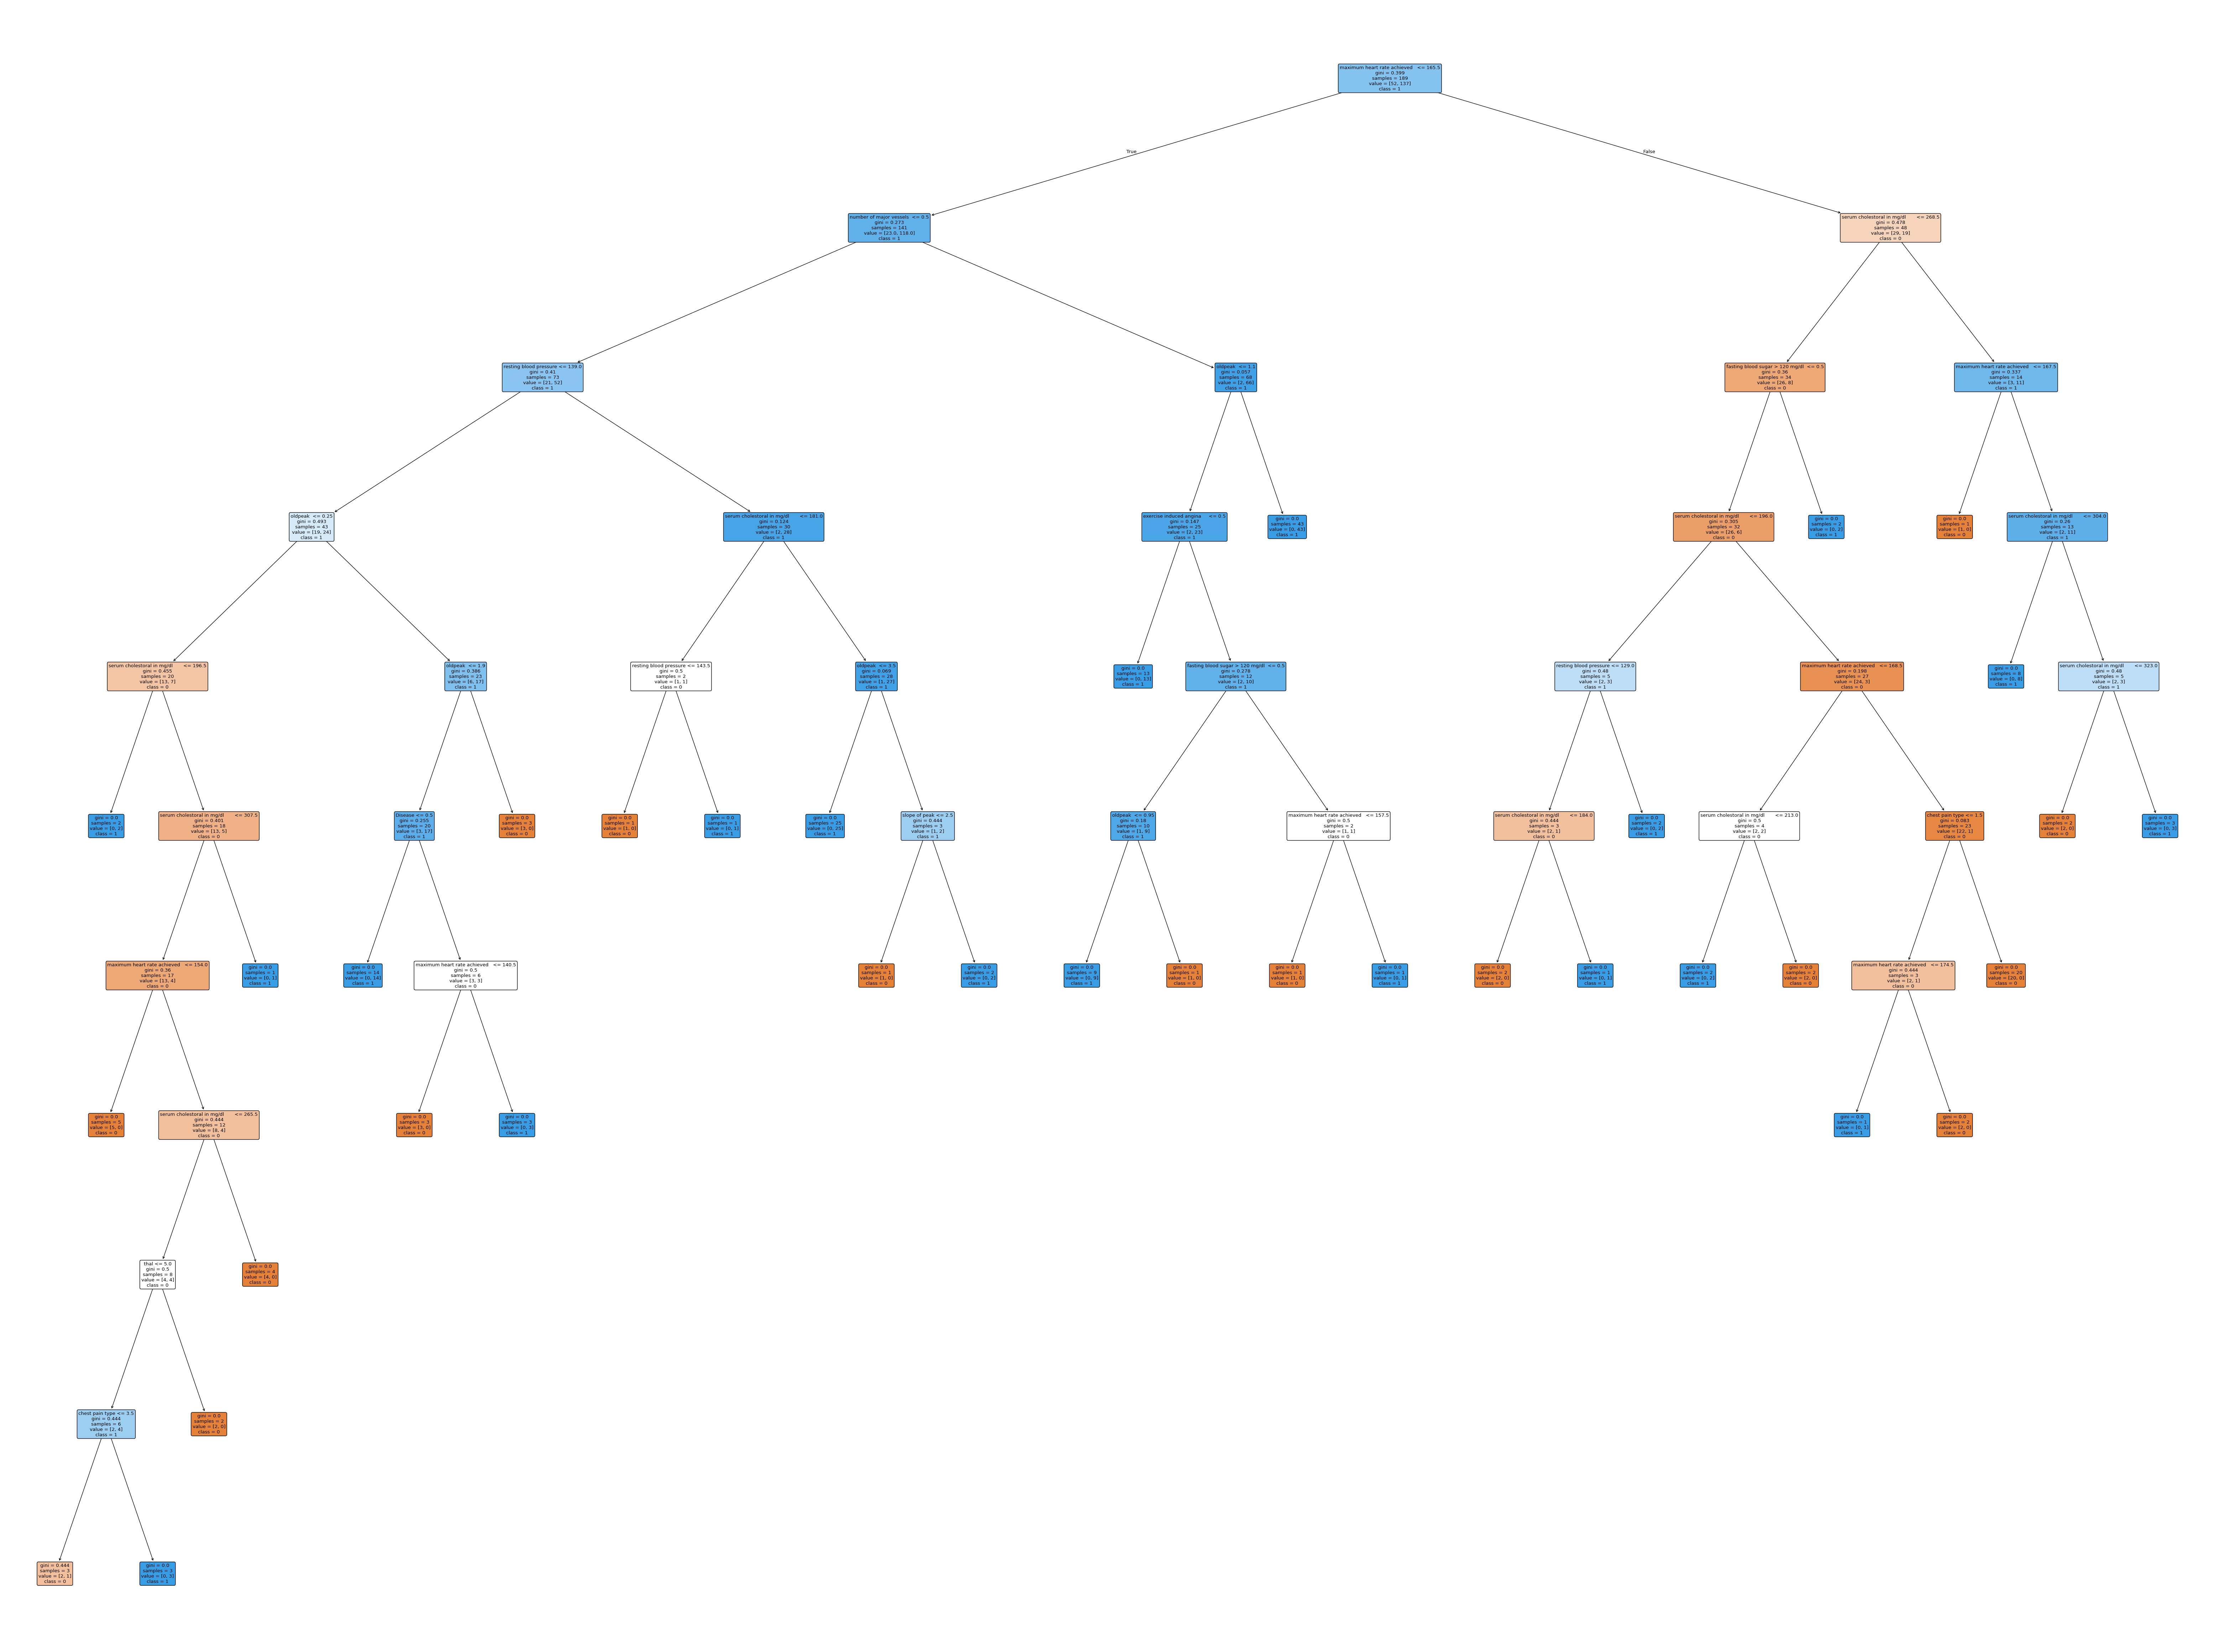

In [59]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(Y.unique())], filled=True, rounded=True)
plt.show()


## 2. Мультиклассовая классификация

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   age                                   270 non-null    int64   
 1   sex                                   270 non-null    category
 2   chest pain type                       270 non-null    int64   
 3   resting blood pressure                270 non-null    int64   
 4   serum cholestoral in mg/dl            270 non-null    int64   
 5   fasting blood sugar > 120 mg/dl       270 non-null    int64   
 6   resting electrocardiographic results  270 non-null    int64   
 7   maximum heart rate achieved           270 non-null    int64   
 8   exercise induced angina               270 non-null    int64   
 9   oldpeak                               270 non-null    float64 
 10  slope of peak                         270 non-null    int64   
 11  number

In [61]:
# Определяем диапазоны и соответствующие значения
bins = [0, 30, 50, 60, 100]  # Диапазоны возраста
labels = [40, 50, 60, 70]    # Соответствующие значения для каждого диапазона

# Применяем метод cut
df['age'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
df['age'] = df['age']


In [62]:
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,old_and_sick
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1,1
1,70,0,3,115,564,0,2,160,0,1.6,2,0,7,0,1
2,60,1,2,124,261,0,0,141,0,0.3,1,0,7,1,1
3,70,1,4,128,263,0,0,105,1,0.2,2,1,7,0,1
4,70,0,2,120,269,0,2,121,1,0.2,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,60,1,3,172,199,1,0,162,0,0.5,1,0,7,0,1
266,50,1,2,120,263,0,0,173,0,0.0,1,0,7,0,0
267,60,0,2,140,294,0,2,153,0,1.3,2,0,3,0,1
268,60,1,4,140,192,0,0,148,0,0.4,2,0,6,0,1


In [63]:
y_multi = df['age']

X_multi = df.drop(['age', 'old_and_sick'], axis=1)

In [64]:
# Создаем копию данных
category_columns: list[str] = X_multi.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_multi = pd.get_dummies(X_multi, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


### Обучаем логистическую регрессию

In [65]:
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(max_iter=1000)
model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = model.predict(X_test_multi)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

          50       0.50      0.46      0.48        28
          60       0.60      0.50      0.55        36
          70       0.36      0.53      0.43        17

    accuracy                           0.49        81
   macro avg       0.49      0.50      0.49        81
weighted avg       0.52      0.49      0.50        81



###OVERSAMPLING

In [67]:
y_multi.value_counts()

,count
age,
60,112
50,85
70,72
40,1


In [68]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_multi, y_multi)


In [69]:
y_res.value_counts()

,count
age,
40,112
50,112
60,112
70,112


###Обучить дерево принятия решений для oversampling

In [70]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_multi, y_multi)


In [71]:
print(y_res.value_counts())


age
40    112
50    112
60    112
70    112
Name: count, dtype: int64


In [72]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [73]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))



Classification Report:
               precision    recall  f1-score   support

          40       1.00      1.00      1.00        33
          50       0.62      0.87      0.72        30
          60       0.54      0.42      0.47        36
          70       0.62      0.56      0.59        36

    accuracy                           0.70       135
   macro avg       0.69      0.71      0.69       135
weighted avg       0.69      0.70      0.69       135




classification_report:

Precision:

40 (1) — у класса 40 всего одно значение в данных, поэтому тяжело что то о нем сказать
50 (0.62) — 62% предсказанных значений,как класс 50, действительно относятся к классу 50.

60 (0.54) — 54% предсказанных значений, как класс 60, действительно относятся к классу 60.

70 (0.62) — 62% предсказанных значений,как класс 70, действительно относятня к классу 70.
Recall:

40 (1) — у класса 40 всего одно значение в данных, поэтому тяжело что то о нем сказать

50 (0.87) — модель нашла 87% всех,которые относятся к классу 1.

60 (0.42) — модель нашла 42% всех значений, которые относятся к классу 0.

70 (0.56) — модель нашла 56% всех,которые относятся к классу 1.



Accuracy = 0.70 — 70% всех предсказаний правильны.

Macro avg — усредненное качество модели по всем классам 69%

Weighted avg — качество модели по количеству примеров каждого класса 69%

In [74]:
accuracy_score(y_test_multi, y_pred_multi)


0.6962962962962963

In [75]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)


0.7097222222222221

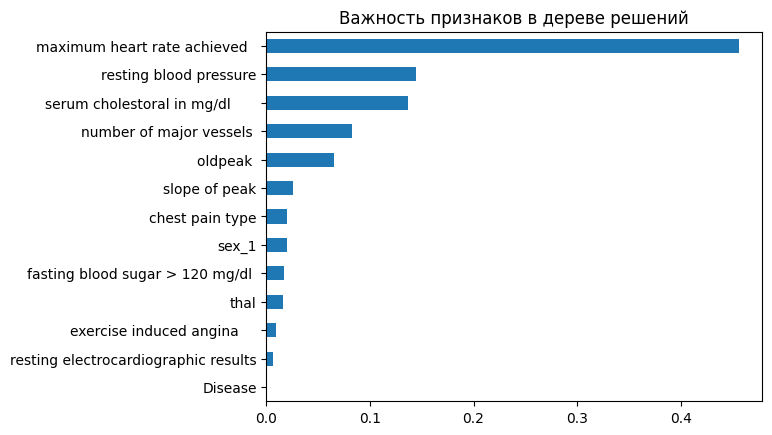

In [76]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X_res.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()


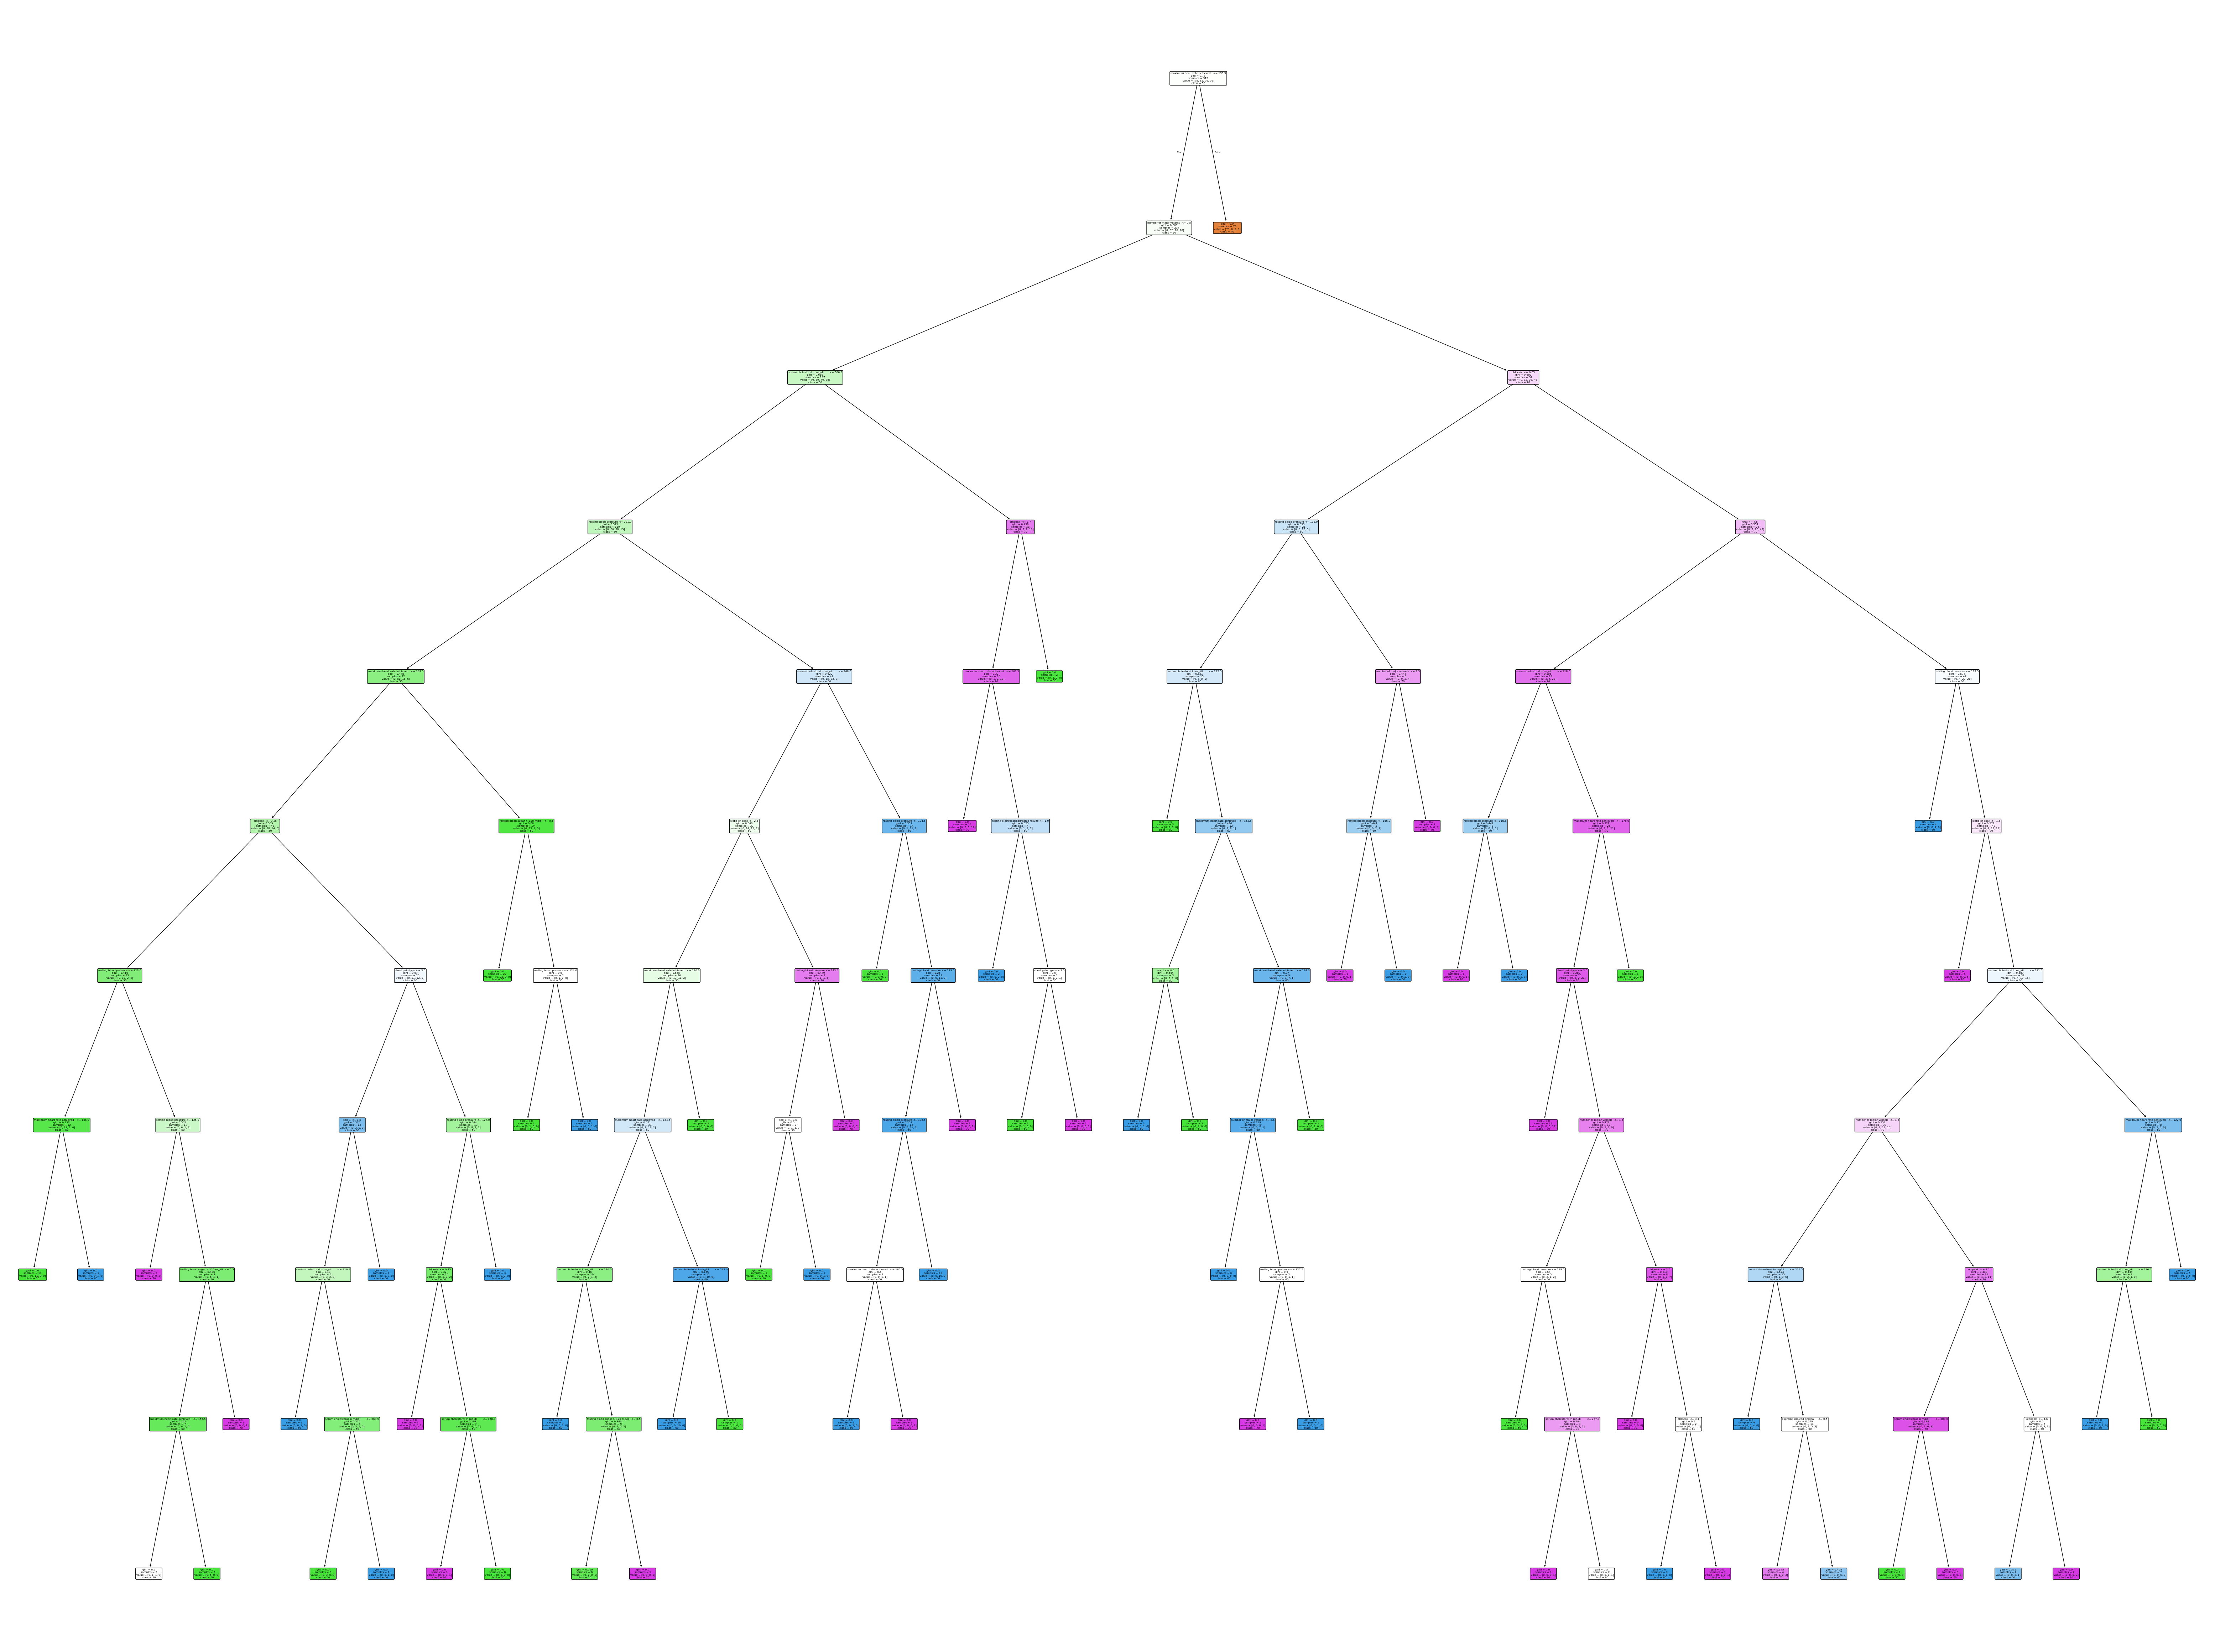

In [77]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X_res.columns, class_names=[str(item) for item in sorted(y_res.unique())], filled=True, rounded=True)
plt.show()
